<a href="https://colab.research.google.com/github/manuelec/nasdaq-prediction-pytorch/blob/main/Advanced_Time_Series_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Creation

In [1]:
# Install yfinance
# !pip install yfinance pandas-datareader

In [2]:
# Import libraries
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from google.colab import auth
from google.auth import default
import gspread
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
#@title Download Data from yfinance
start_date = "2018-01-02"
end_date = "2024-12-01"

# Download NASDAQ and S&P 500 data from Yahoo Finance
nasdaq_data = yf.download("^IXIC", start=start_date, end=end_date)  # ^IXIC is the ticker for NASDAQ
sp500_data = yf.download("^GSPC", start=start_date, end=end_date)  # ^GSPC is the ticker for S&P 500

# Download Treasury yield and VIX from FRED
treasury_yield = web.DataReader("DGS10", "fred", start_date, end_date)
vix = web.DataReader("VIXCLS", "fred", start_date, end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
#@title Dataframe preparation
# Rename columns for clarity and to avoid duplicates
nasdaq_data = nasdaq_data.rename(columns={"Close": "nasdaq_close"})
sp500_data = sp500_data.rename(columns={"Close": "sp500_close"})

# Select the correct columns using the MultiIndex
nasdaq_close = nasdaq_data[('nasdaq_close', '^IXIC')]  # Accessing 'nasdaq_close' under 'Price' level and '^IXIC' under 'Ticker' level
sp500_close = sp500_data[('sp500_close', '^GSPC')]  # Accessing 'sp500_close' under 'Price' level and '^GSPC' under 'Ticker' level

# Convert the Series to DataFrames
nasdaq_close = pd.DataFrame(nasdaq_close)
sp500_close = pd.DataFrame(sp500_close)

# Merge the DataFrames
combined_df = nasdaq_close
combined_df = combined_df.join(sp500_close, how="left")

# Reset the index and flatten the MultiIndex columns
combined_df = combined_df.reset_index()
combined_df.columns = combined_df.columns.to_flat_index()

# Rename the columns
combined_df = combined_df.rename(
    columns={
        ("Date", ""): "Date",
        ("nasdaq_close", "^IXIC"): "nasdaq_close",
        ("sp500_close", "^GSPC"): "sp500_close",
    }
)

# Convert 'Date'
combined_df['Date'] = pd.to_datetime(combined_df['Date']).dt.tz_localize(None)

# Join with treasury_yield and vix
combined_df = combined_df.join(treasury_yield, how="left", on="Date")
combined_df = combined_df.join(vix, how="left", on="Date")

# Handle missing values (if any)
combined_df = combined_df.ffill()

# Print and check
print(combined_df.head())

        Date  nasdaq_close  sp500_close  DGS10  VIXCLS
0 2018-01-02   7006.899902  2695.810059   2.46    9.77
1 2018-01-03   7065.529785  2713.060059   2.44    9.15
2 2018-01-04   7077.910156  2723.989990   2.46    9.22
3 2018-01-05   7136.560059  2743.149902   2.47    9.22
4 2018-01-08   7157.390137  2747.709961   2.49    9.52


- uncomment if needed to export to Google Sheet, else leave it

In [5]:
#@title Export to Google Sheet and CSV locally
# # !pip install gspread oauth2client

# # Authenticate and create the Google Sheets connection
# auth.authenticate_user()
# creds, _ = default()
# gc = gspread.authorize(creds)

# # Create a new spreadsheet
# sh = gc.create('Combined_Dataset')

# # Open the spreadsheet
# worksheet = gc.open('Combined_Dataset').sheet1

# # Convert 'Date' column to string before exporting
# combined_df['date'] = combined_df['date'].astype(str)

# # Export the DataFrame to Google Sheets
# worksheet.update([combined_df.columns.values.tolist()] + combined_df.values.tolist())

# # Get the URL of the newly created spreadsheet
# spreadsheet_url = sh.url
# print(f"Spreadsheet URL: {spreadsheet_url}")

# exporting as csv for covenience in local folder
# combined_df.to_csv('./Combined_Dataset.csv', index=False)

<Axes: xlabel='Date'>

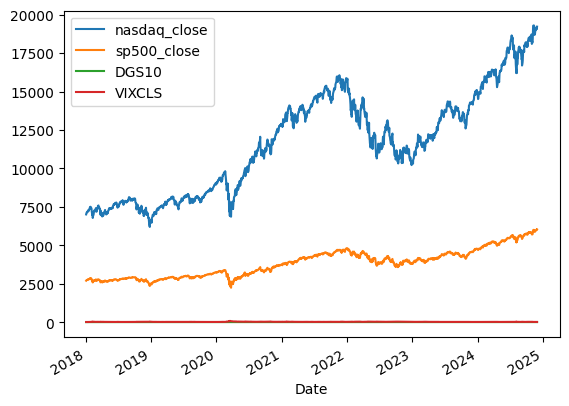

In [6]:
combined_df.plot(x='Date')



---





---



# MLP for Time Series

In [7]:
#@title Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import copy
import torch.nn.utils
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
# import BayesianOptimization
import random

In [8]:
#@title Set the dataset to use
# data = pd.read_csv('/content/Combined_Dataset.csv')
data = combined_df
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

In [9]:
#@title Create new derivate variable and handle NaN values in the data preprocessing stage
def preprocess_data(data):
    # Handle NaN values first
    data = data.ffill()  # Forward fill
    data = data.bfill()  # Backward fill for any remaining NaNs

    # Create engineered features
    data['log_nasdaq'] = np.log(data['nasdaq_close'])
    data['log_sp500'] = np.log(data['sp500_close'])
    data['nasdaq_returns'] = data['nasdaq_close'].pct_change()
    data['sp500_returns'] = data['sp500_close'].pct_change()
    data['nasdaq_volatility'] = data['nasdaq_returns'].rolling(window=21).std()
    data['nasdaq_ma50'] = data['nasdaq_close'].rolling(window=50).mean()
    data['sp500_ma50'] = data['sp500_close'].rolling(window=50).mean()
    data['relative_strength'] = data['nasdaq_close'] / data['sp500_close']

    # Fill NaN values created by rolling operations
    data = data.bfill()

    return data

# 2. Modify the scaling and sequence creation
# Apply preprocessing
data = preprocess_data(data)

## DataViz

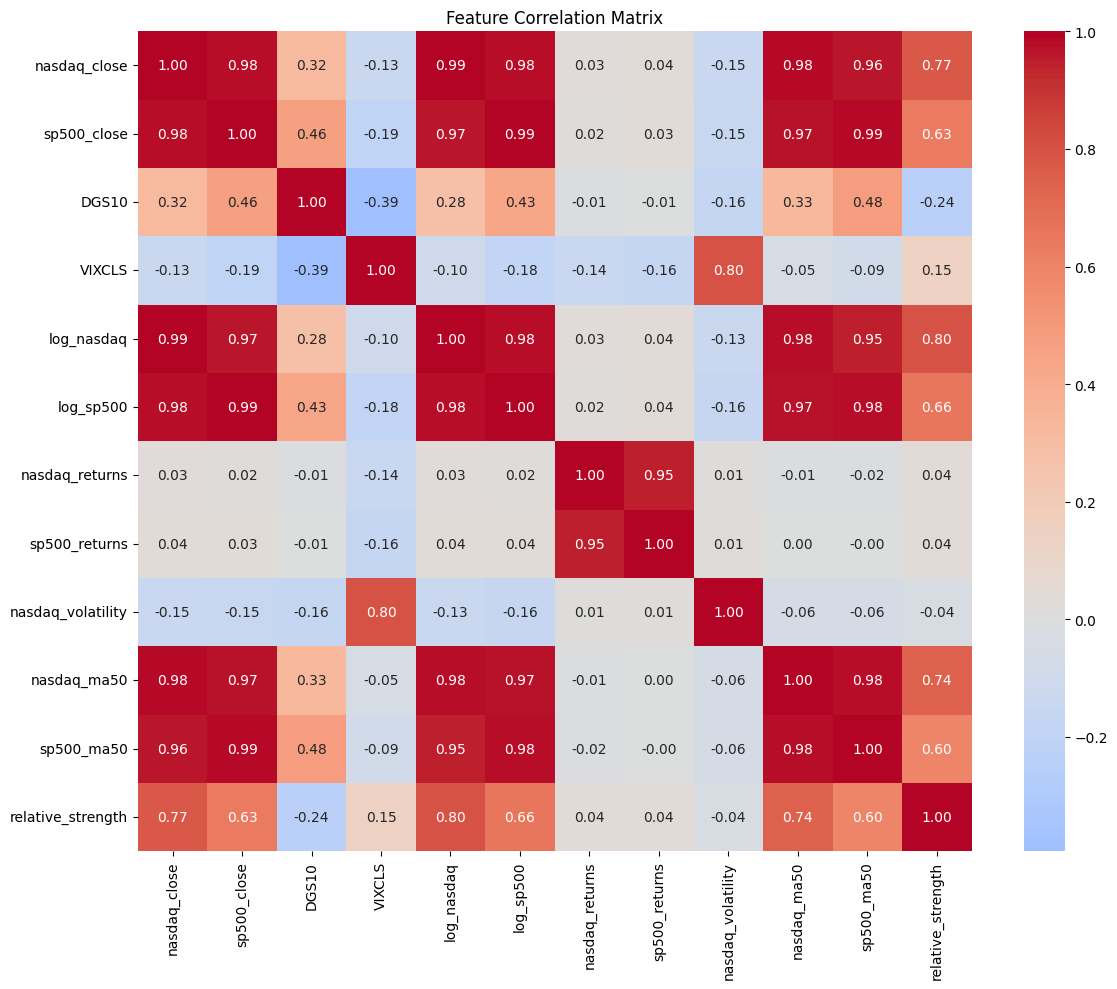

In [10]:
# Calculate correlation matrix for all features
correlation_matrix = data[[
    'nasdaq_close', 'sp500_close', 'DGS10', 'VIXCLS',
    'log_nasdaq', 'log_sp500', 'nasdaq_returns', 'sp500_returns',
    'nasdaq_volatility', 'nasdaq_ma50', 'sp500_ma50', 'relative_strength'
]].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f'Stationarity Test for {name}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    print('-' * 40)

# Test stationarity for each feature
features_to_test = [
    'nasdaq_returns', 'sp500_returns', 'nasdaq_volatility',
    'relative_strength', 'log_nasdaq', 'log_sp500'
]

for feature in features_to_test:
    check_stationarity(data[feature], feature)

Stationarity Test for nasdaq_returns:
ADF Statistic: -13.3992
p-value: 0.0000
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5677
----------------------------------------
Stationarity Test for sp500_returns:
ADF Statistic: -12.8402
p-value: 0.0000
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5677
----------------------------------------
Stationarity Test for nasdaq_volatility:
ADF Statistic: -3.9244
p-value: 0.0019
Critical Values:
	1%: -3.4342
	5%: -2.8632
	10%: -2.5677
----------------------------------------
Stationarity Test for relative_strength:
ADF Statistic: -1.6821
p-value: 0.4403
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5677
----------------------------------------
Stationarity Test for log_nasdaq:
ADF Statistic: -0.7004
p-value: 0.8467
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5677
----------------------------------------
Stationarity Test for log_sp500:
ADF Statistic: -0.3750
p-value: 0.9142
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -

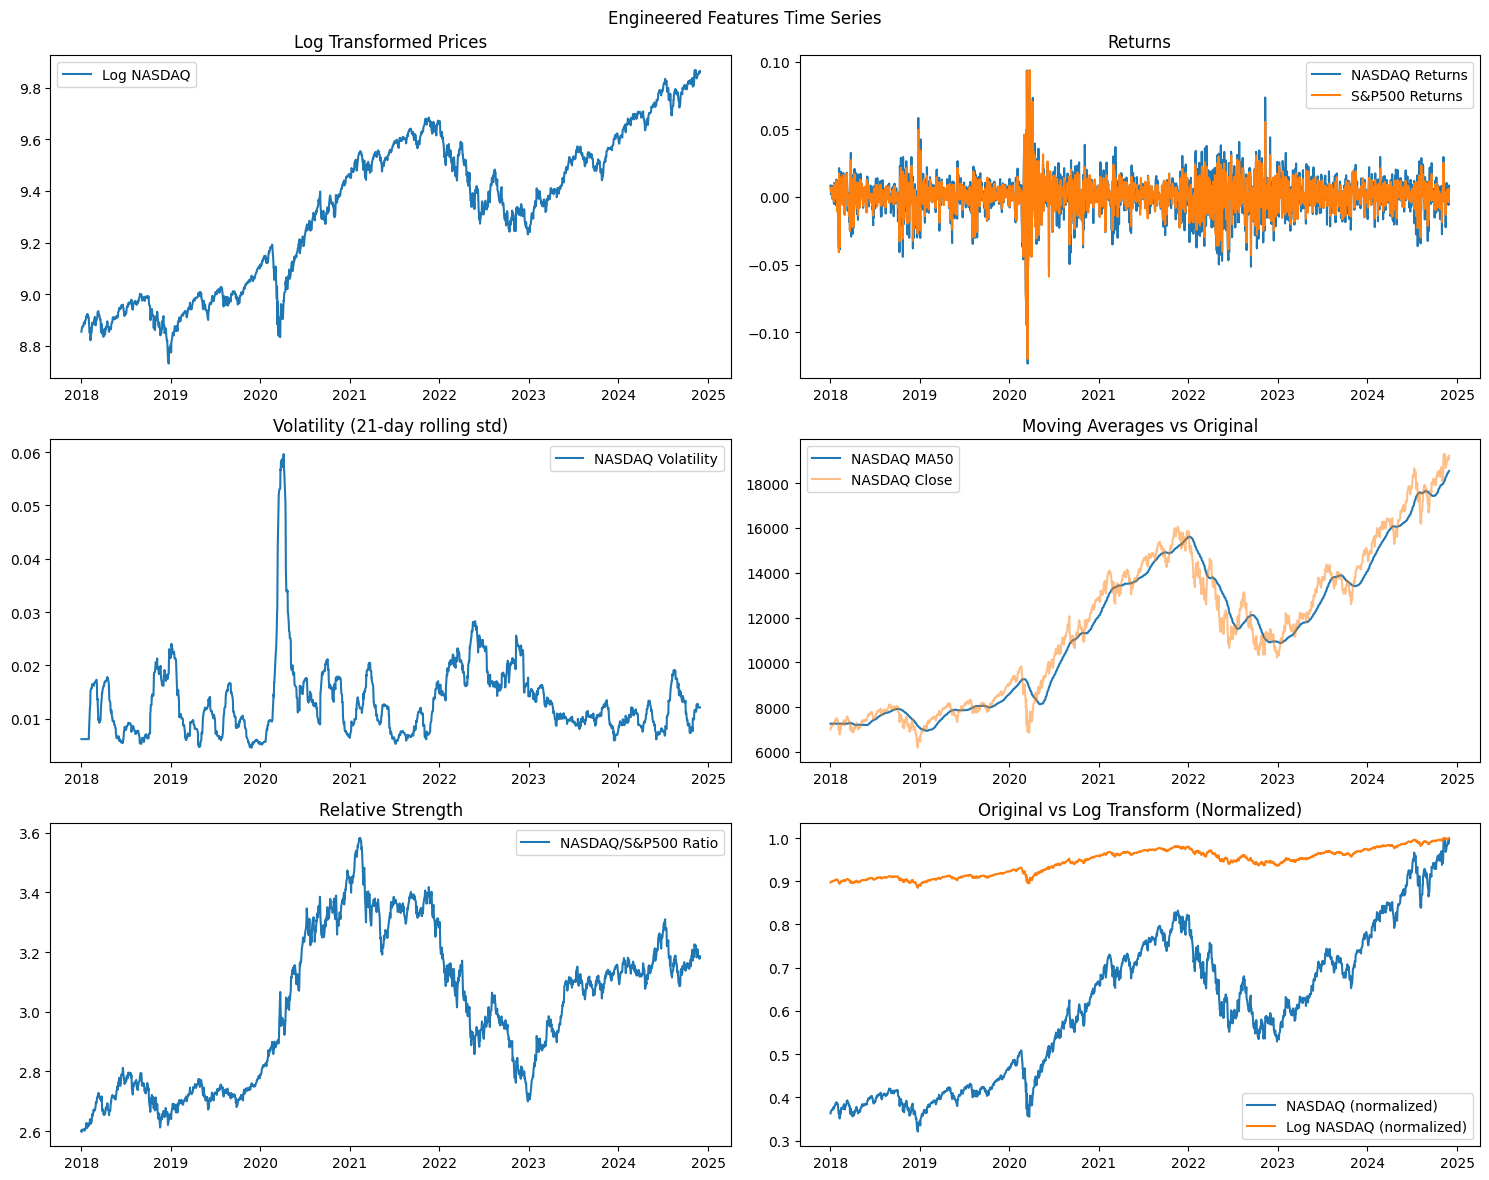

In [12]:
# Plot time series of engineered features
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Engineered Features Time Series')

# Log transformations
axes[0,0].plot(data.index, data['log_nasdaq'], label='Log NASDAQ')
axes[0,0].set_title('Log Transformed Prices')
axes[0,0].legend()

# Returns
axes[0,1].plot(data.index, data['nasdaq_returns'], label='NASDAQ Returns')
axes[0,1].plot(data.index, data['sp500_returns'], label='S&P500 Returns')
axes[0,1].set_title('Returns')
axes[0,1].legend()

# Volatility
axes[1,0].plot(data.index, data['nasdaq_volatility'], label='NASDAQ Volatility')
axes[1,0].set_title('Volatility (21-day rolling std)')
axes[1,0].legend()

# Moving averages
axes[1,1].plot(data.index, data['nasdaq_ma50'], label='NASDAQ MA50')
axes[1,1].plot(data.index, data['nasdaq_close'], label='NASDAQ Close', alpha=0.5)
axes[1,1].set_title('Moving Averages vs Original')
axes[1,1].legend()

# Relative strength
axes[2,0].plot(data.index, data['relative_strength'], label='NASDAQ/S&P500 Ratio')
axes[2,0].set_title('Relative Strength')
axes[2,0].legend()

# Original vs Log transformation comparison
axes[2,1].plot(data.index, data['nasdaq_close']/data['nasdaq_close'].max(),
               label='NASDAQ (normalized)')
axes[2,1].plot(data.index, data['log_nasdaq']/data['log_nasdaq'].max(),
               label='Log NASDAQ (normalized)')
axes[2,1].set_title('Original vs Log Transform (Normalized)')
axes[2,1].legend()

plt.tight_layout()
plt.show()

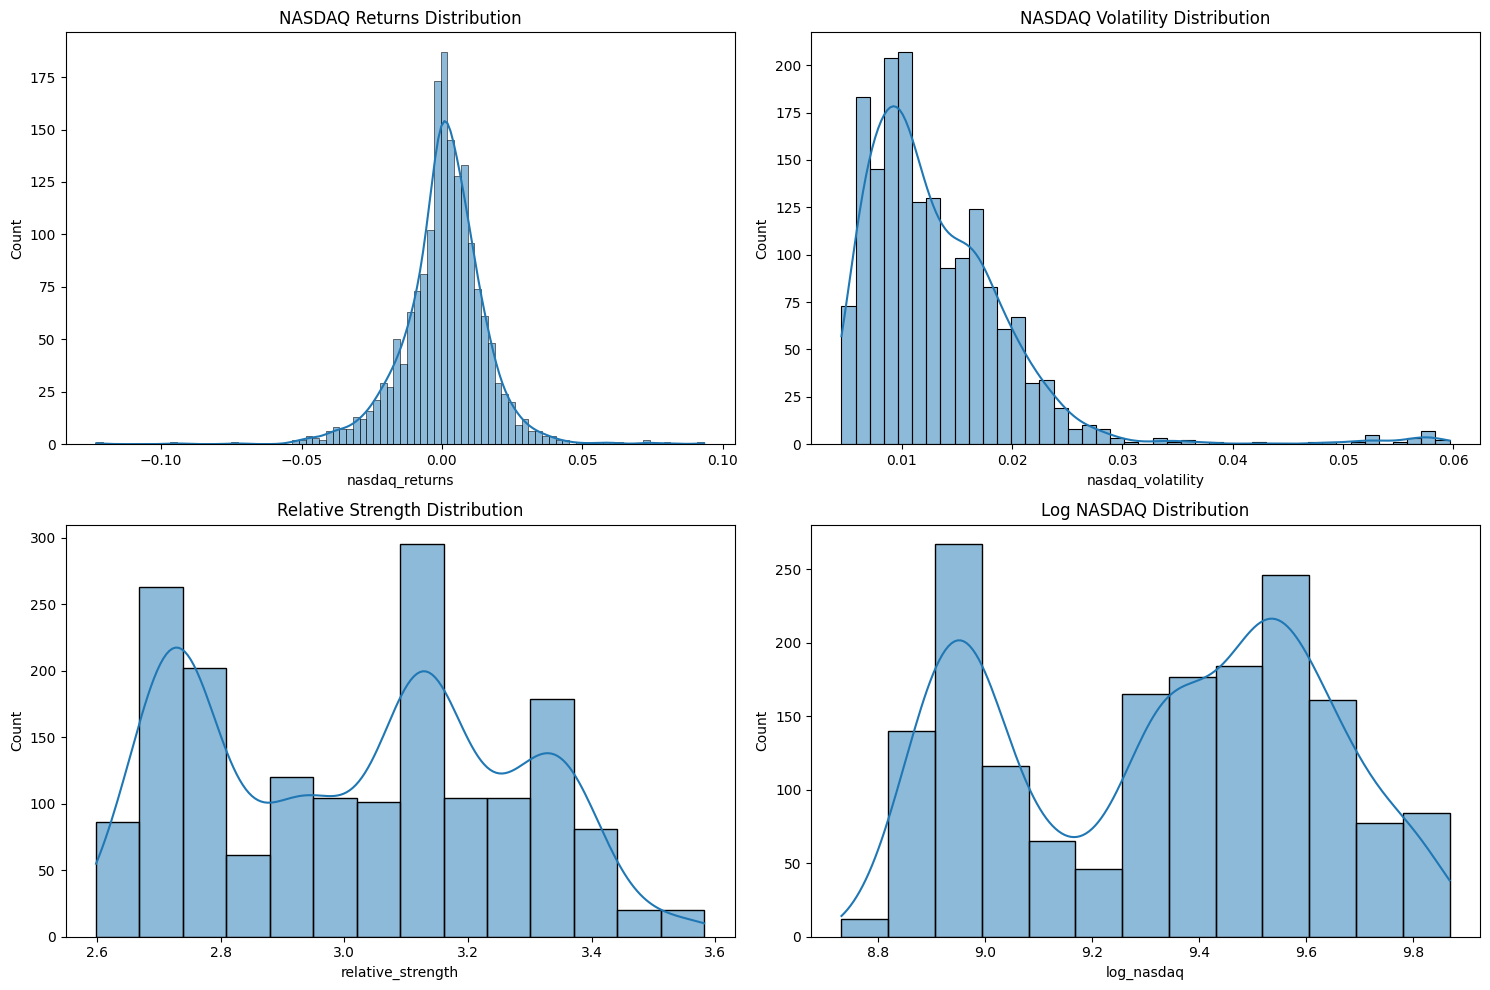

In [13]:
# Plot distribution of returns and volatility
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(data['nasdaq_returns'].dropna(), kde=True, ax=axes[0,0])
axes[0,0].set_title('NASDAQ Returns Distribution')

sns.histplot(data['nasdaq_volatility'].dropna(), kde=True, ax=axes[0,1])
axes[0,1].set_title('NASDAQ Volatility Distribution')

sns.histplot(data['relative_strength'].dropna(), kde=True, ax=axes[1,0])
axes[1,0].set_title('Relative Strength Distribution')

sns.histplot(data['log_nasdaq'].dropna(), kde=True, ax=axes[1,1])
axes[1,1].set_title('Log NASDAQ Distribution')

plt.tight_layout()
plt.show()



---



## Datasets creation (training, val, test)

In [14]:
#@title Define features and target
features = [
    'sp500_close', 'DGS10', 'VIXCLS',
    'log_sp500', 'sp500_returns', 'nasdaq_volatility',
    'sp500_ma50', 'relative_strength']

target = 'nasdaq_close'

# Get the column indices before scaling
feature_indices = [data.columns.get_loc(feature) for feature in features]
target_index = data.columns.get_loc(target)

- Validation Set: Used during training to monitor model performance and prevent overfitting. It represents 15% of the data  after the training set.
The validation set helps tune hyperparameters, while the test set provides an unbiased evaluation of the final model's performance.

- Test Set: Used only for final evaluation of the model's performance. It represents the last 15% of the data after the validation set.

We're creating a list of column indices for only these 8 selected features, excluding:
- nasdaq_close (target variable)
- log_nasdaq
- nasdaq_returns
- nasdaq_ma50

In [15]:
#@title Calculate split points for training, validation and test
total_days = len(data)
train_size = int(0.7 * total_days)
val_size = int(0.15 * total_days)
test_size = total_days - train_size - val_size

print(f"Total days: {total_days}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

Total days: 1740
Train size: 1218
Validation size: 261
Test size: 261


In [16]:
#@title Split Data into Training / Validation / Test
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

In [17]:
data.columns

Index(['nasdaq_close', 'sp500_close', 'DGS10', 'VIXCLS', 'log_nasdaq',
       'log_sp500', 'nasdaq_returns', 'sp500_returns', 'nasdaq_volatility',
       'nasdaq_ma50', 'sp500_ma50', 'relative_strength'],
      dtype='object')

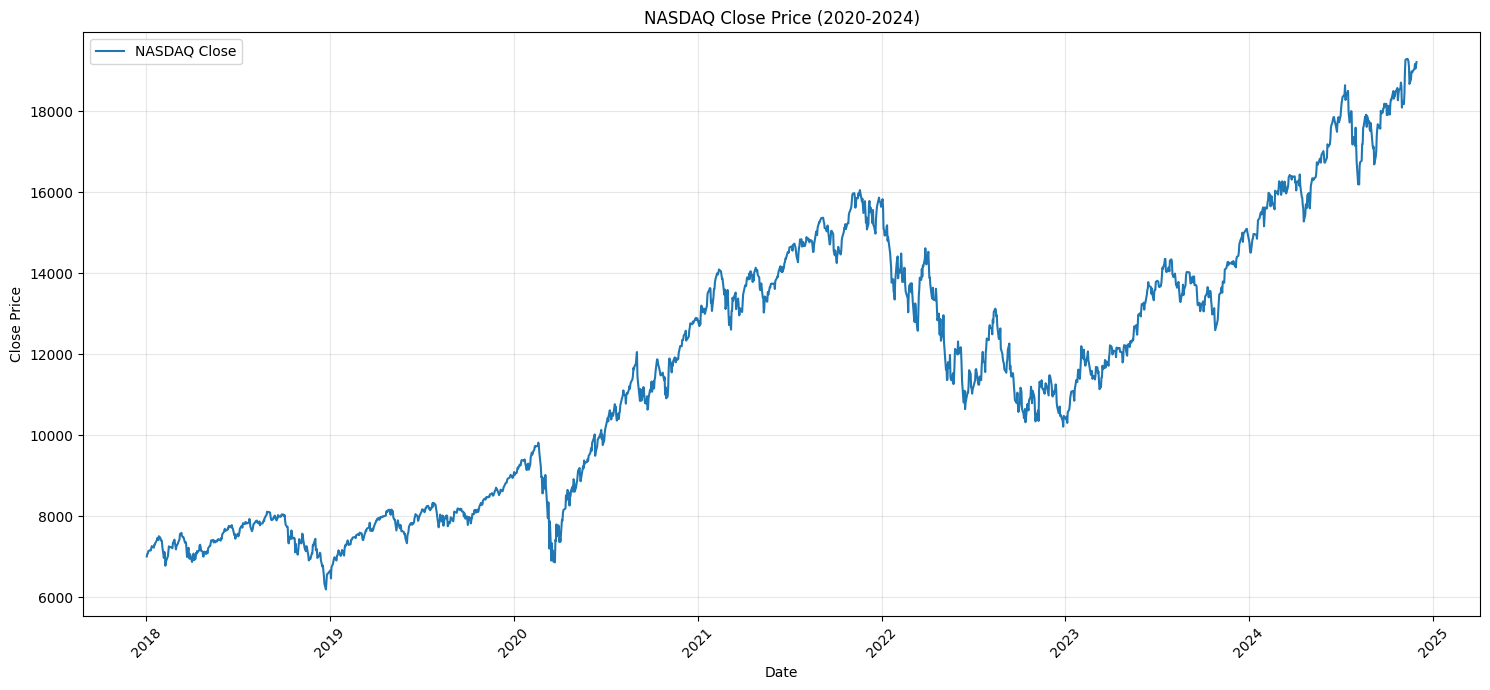

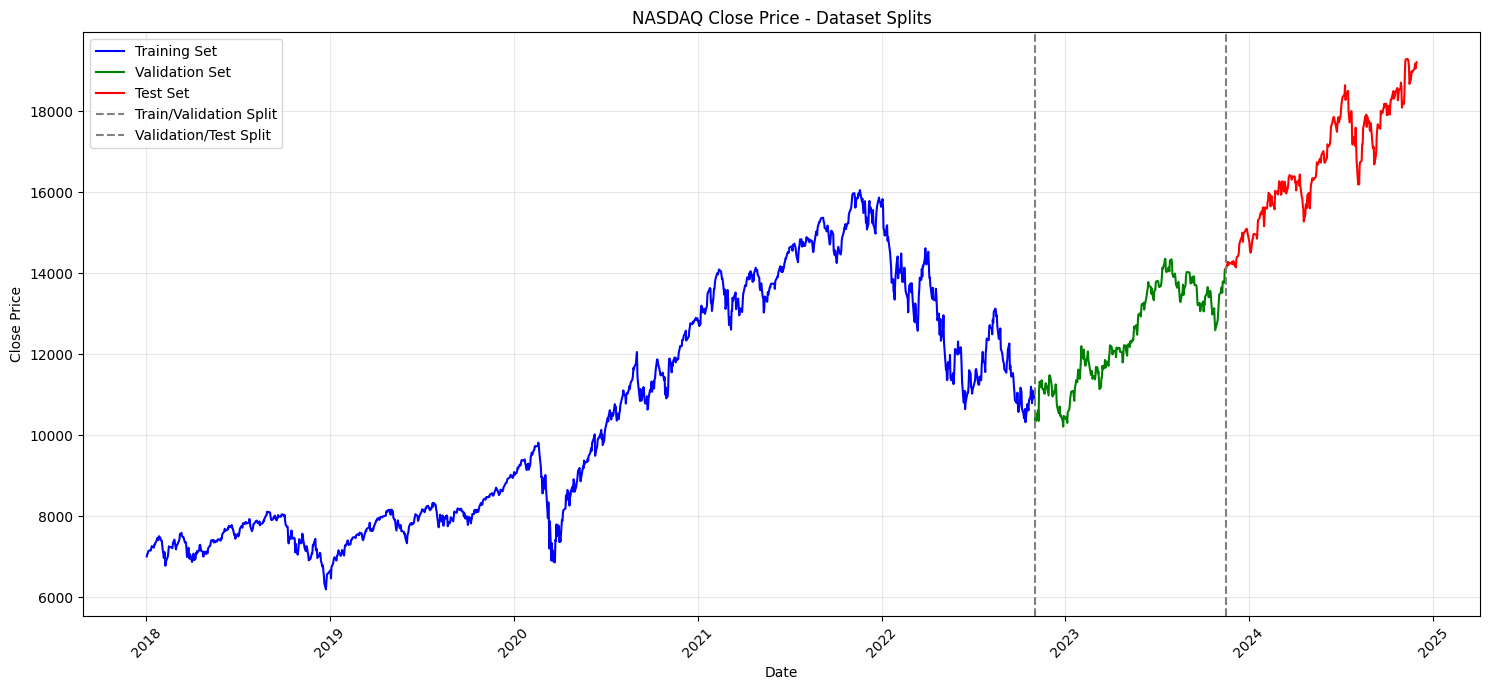

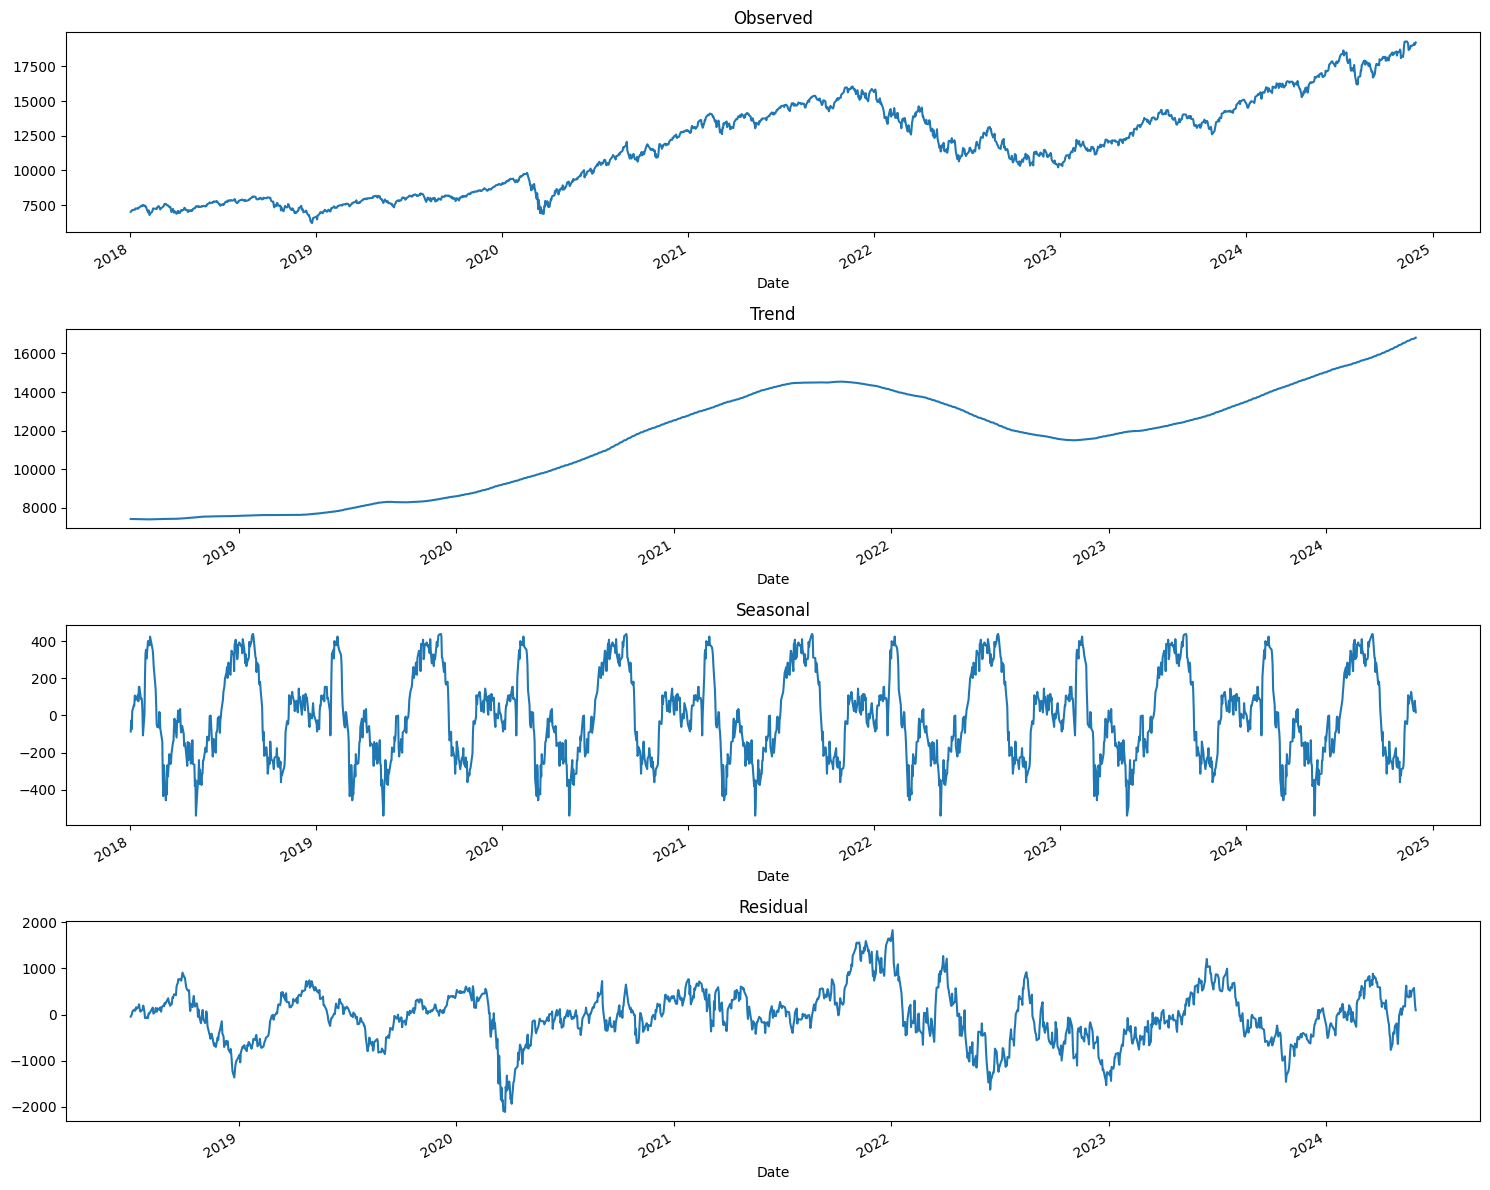

In [18]:
#@title DataViz Target time series split

plt.figure(figsize=(15, 7))
plt.plot(data.index, data['nasdaq_close'], label='NASDAQ Close')
plt.title('NASDAQ Close Price (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize train/validation/test splits
plt.figure(figsize=(15, 7))
plt.plot(data.index[:train_size], data['nasdaq_close'][:train_size],
         label='Training Set', color='blue')
plt.plot(data.index[train_size:train_size+val_size],
         data['nasdaq_close'][train_size:train_size+val_size],
         label='Validation Set', color='green')
plt.plot(data.index[train_size+val_size:],
         data['nasdaq_close'][train_size+val_size:],
         label='Test Set', color='red')
plt.axvline(x=data.index[train_size], color='gray', linestyle='--',
            label='Train/Validation Split')
plt.axvline(x=data.index[train_size+val_size], color='gray', linestyle='--',
            label='Validation/Test Split')
plt.title('NASDAQ Close Price - Dataset Splits')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time series decomposition
decomposition = seasonal_decompose(data['nasdaq_close'], period=252)  # 252 trading days in a year

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

In [19]:
#@title Scaling the data
scaler = MinMaxScaler(feature_range=(-1, 1))

scaled_train = scaler.fit_transform(train_data)
scaled_val = scaler.transform(val_data)
scaled_test = scaler.transform(test_data)



---



## Classes and Functions

In [20]:
#@title set fixed seed
def set_seeds(seed=42):
    # Python and NumPy
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

    return seed

# Apply seeds before creating DataLoaders
seed = set_seeds()

In [21]:
#@title Function Create sequences and check NaN
def create_sequences(data, seq_length, feature_indices, target_index):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, feature_indices]
        target = data[i+seq_length, target_index]

        # Check for NaN values
        if not (np.isnan(seq).any() or np.isnan(target).any()):
            X.append(seq)
            y.append(target)

    return np.array(X), np.array(y)

In [22]:
#@title Class Create TimeSeriesDataset
class TimeSeriesDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.FloatTensor(features)
        self.target = torch.FloatTensor(target)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

In [23]:
#@title Function Add gradient normalization
def normalize_gradients(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

In [24]:
#@title Function Train_and_validate
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None
    accumulation_steps = 2
    warmup_epochs = 3

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    for epoch in range(epochs):
        # Warmup period
        if epoch < warmup_epochs:
            lr_scale = min(1., float(epoch + 1) / warmup_epochs)
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * pg['lr']

        # Training Phase
        model.train()
        train_loss = 0.0
        optimizer.zero_grad()

        for batch_idx, (data, target) in enumerate(train_loader):
            # Check for NaN values
            if torch.isnan(data).any() or torch.isnan(target).any():
                print(f"NaN values detected in batch {batch_idx}")
                continue

            output = model(data).squeeze()
            loss = criterion(output, target)

            # Gradient accumulation
            loss = loss / accumulation_steps
            loss.backward()

            grad_norm = normalize_gradients(model)
            if batch_idx % 10 == 0:
                print(f'Gradient norm: {grad_norm:.4f}')

            # Update weights after accumulation steps
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * accumulation_steps

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Train Loss: {loss.item()*accumulation_steps:.4f}')

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data).squeeze()
                loss = criterion(output, target)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model state
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = {
                'model': copy.deepcopy(model.state_dict()),
                'optimizer': copy.deepcopy(optimizer.state_dict()),
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss
            }
            patience_counter = 0
        else:
            patience_counter += 1

        print(f'Epoch {epoch+1}')
        print(f'Average Train Loss: {avg_train_loss:.4f}')
        print(f'Average Validation Loss: {avg_val_loss:.4f}')
        print('-' * 60)

        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    # Load best model state
    if best_state is not None:
        model.load_state_dict(best_state['model'])
        optimizer.load_state_dict(best_state['optimizer'])

    return model, train_losses, val_losses



---



## Neural Network

In [25]:
#@title Model 1 MLPForTimeSeries neural network
class MLPForTimeSeries(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.3):
        super(MLPForTimeSeries, self).__init__()
        self.flatten = nn.Flatten()

        # First block
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Residual blocks
        self.res1_fc1 = nn.Linear(hidden_size, hidden_size)
        self.res1_bn1 = nn.BatchNorm1d(hidden_size)
        self.res1_fc2 = nn.Linear(hidden_size, hidden_size)
        self.res1_bn2 = nn.BatchNorm1d(hidden_size)

        self.res2_fc1 = nn.Linear(hidden_size, hidden_size)
        self.res2_bn1 = nn.BatchNorm1d(hidden_size)
        self.res2_fc2 = nn.Linear(hidden_size, hidden_size)
        self.res2_bn2 = nn.BatchNorm1d(hidden_size)

        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)

        # Initial projection
        x = F.relu(self.bn1(self.hidden1(x)))
        x = self.dropout1(x)

        # Residual block 1
        identity = x
        x = F.relu(self.res1_bn1(self.res1_fc1(x)))
        x = self.res1_bn2(self.res1_fc2(x))
        x = F.relu(x + identity)

        # Residual block 2
        identity = x
        x = F.relu(self.res2_bn1(self.res2_fc1(x)))
        x = self.res2_bn2(self.res2_fc2(x))
        x = F.relu(x + identity)

        return self.output(x)

In [26]:
#@title Model 2 TimeAttention Model
class TimeSeriesAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.3):
        super(TimeSeriesAttention, self).__init__()
        self.hidden_size = hidden_size

        # Attention components
        self.attention = nn.Linear(hidden_size, 1)

        # Main network
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        # Project to hidden space
        h = F.relu(self.bn1(self.fc1(x.view(batch_size, -1))))

        # Apply attention
        attention_weights = F.softmax(self.attention(h), dim=1)
        attended = h * attention_weights

        # Final prediction
        out = self.dropout(attended)
        return self.fc2(out)



---



**TimeSeriesAttention Handling of Variables:**

- The TimeSeriesAttention model processes the input data as follows:

- Takes the 8 selected features as input (sequence_length * len(features))
- Applies attention mechanism to focus on relevant temporal patterns
- Outputs a single value (NASDAQ close price prediction)


The model doesn't explicitly distinguish between target and covariates in its architecture - it learns the relationships through training

# Train the model

In [27]:
#@title Create sequences for each dataset
sequence_length = 10 # to change, initial setup
X_train, y_train = create_sequences(scaled_train, sequence_length, feature_indices, target_index)
X_val, y_val = create_sequences(scaled_val, sequence_length, feature_indices, target_index)
X_test, y_test = create_sequences(scaled_test, sequence_length, feature_indices, target_index)

In [28]:
#@title Create Datasets / Dataloaders

batch_size = 128  # Increased batch size for more stable gradients


train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)


# Modify DataLoader initialization
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Force single-thread operation
    generator=torch.Generator().manual_seed(seed)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    generator=torch.Generator().manual_seed(seed)
)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    generator=torch.Generator().manual_seed(seed)
)

In [29]:
#@title Model Parameters
input_size = sequence_length * len(features)  # xx * 8 = xx
hidden_size = 256  # hidden size
dropout_rate = 0.1
num_classes = 1
lr = 0.0003

In [30]:
#@title Define Model (Residual connections or Attention?)

# First model: residual connections
# model = MLPForTimeSeries(input_size, hidden_size, num_classes, dropout_rate)

# Second model: TimeSeriesAttention

model = TimeSeriesAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=1,
    dropout_rate=dropout_rate
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Gradient norm: 1.5789
Epoch 1, Batch 0, Train Loss: 0.0819
Epoch 1
Average Train Loss: 0.1089
Average Validation Loss: 0.0077
------------------------------------------------------------
Gradient norm: 2.8734
Epoch 2, Batch 0, Train Loss: 0.1026
Epoch 2
Average Train Loss: 0.1064
Average Validation Loss: 0.0117
------------------------------------------------------------
Gradient norm: 2.6959
Epoch 3, Batch 0, Train Loss: 0.0907
Epoch 3
Average Train Loss: 0.1040
Average Validation Loss: 0.0152
------------------------------------------------------------
Gradient norm: 2.6334
Epoch 4, Batch 0, Train Loss: 0.0801
Epoch 4
Average Train Loss: 0.1091
Average Validation Loss: 0.0180
------------------------------------------------------------
Gradient norm: 2.8113
Epoch 5, Batch 0, Train Loss: 0.1058
Epoch 5
Average Train Loss: 0.1190
Average Validation Loss: 0.0193
------------------------------------------------------------
Gradient norm: 2.5435
Epoch 6, Batch 0, Train Loss: 0.0761
Epoch 

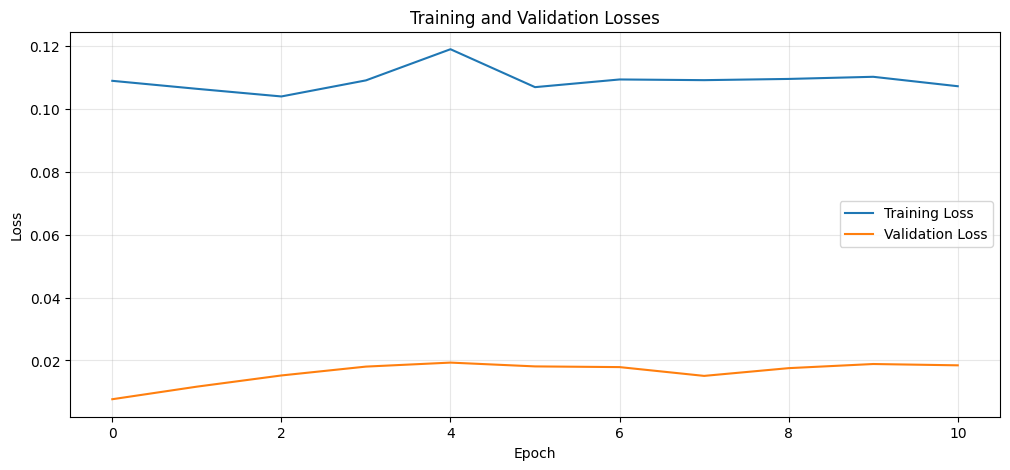

In [45]:
#@title Train the Model >>>
epochs = 40
patience = 10
model, train_losses, val_losses = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, epochs, patience
)


# Plot training curves
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



---



## Make predictions

The data_columns utilized in make_predictions is primarily used in the make_predictions function to:
- Create dummy arrays for inverse transformation
- Locate the nasdaq_close index
- Transform predictions back to original scale

The model itself only sees the 8 selected features during training and prediction.


Validation Set Performance Metrics:
MSE: 184716.56
RMSE: 429.79
MAE: 317.65
R2 Score: 0.8550


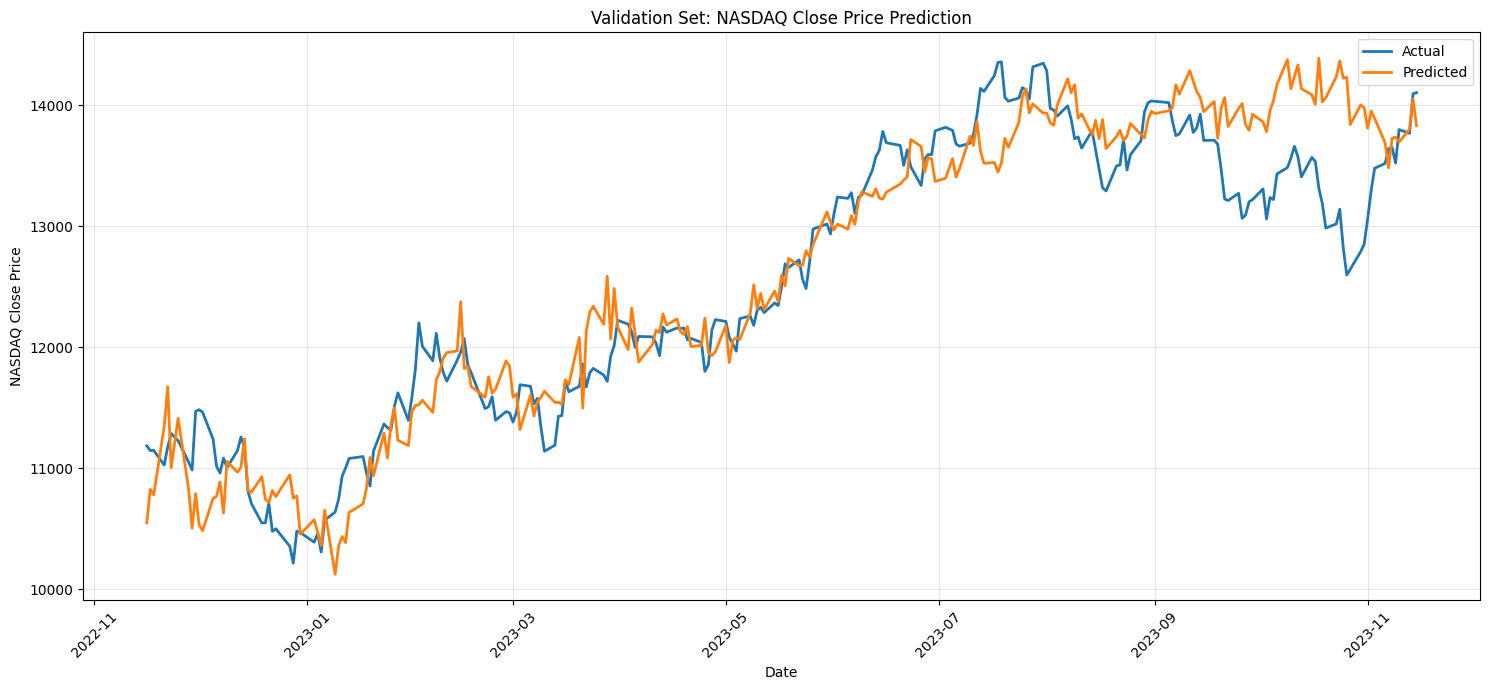


Test Set Performance Metrics:
MSE: 773448.75
RMSE: 879.46
MAE: 772.62
R2 Score: 0.5478


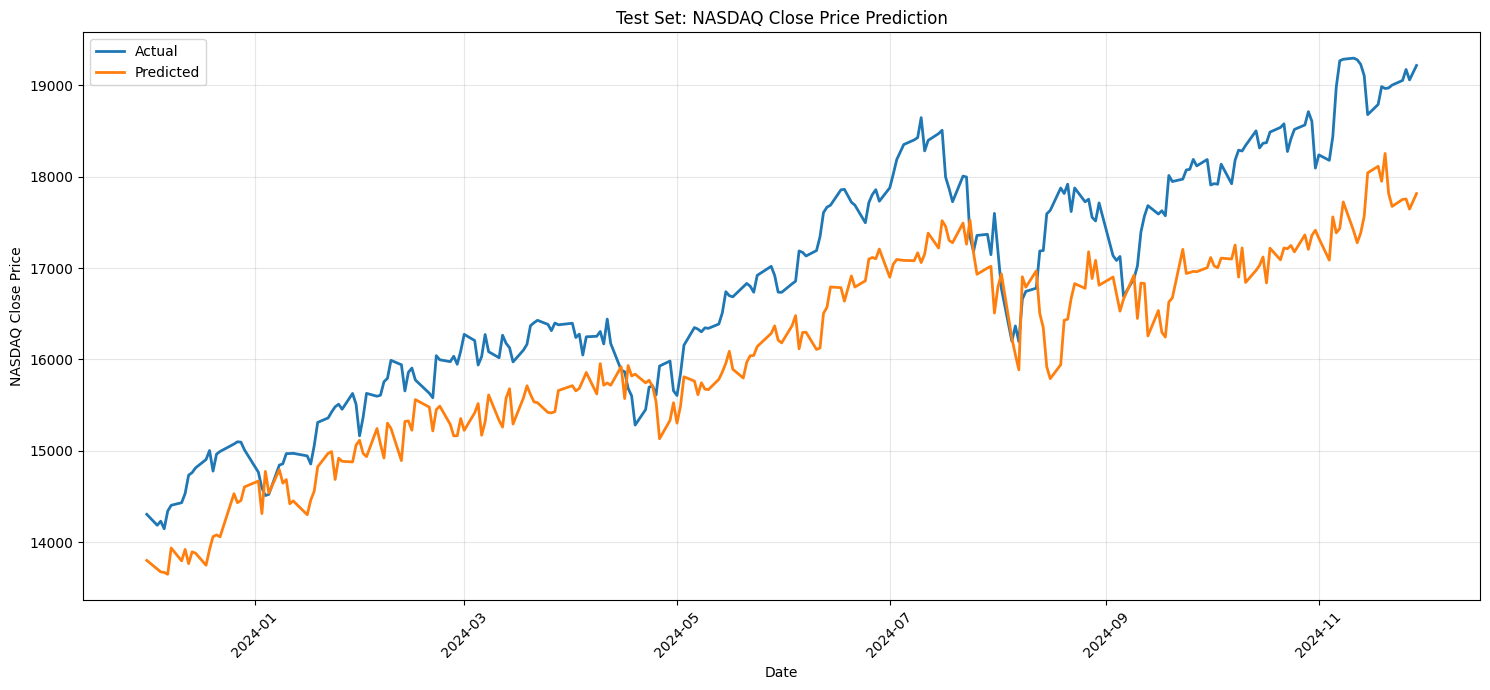

In [46]:
#@title Make predictions on Eval and Test, performance metrics and DataViz
def make_predictions(model, data_loader, scaler, data_columns):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for features, targets in data_loader:
            output = model(features).squeeze()
            predictions.extend(output.numpy())
            actuals.extend(targets.numpy())

    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)

    predictions_dummy = np.zeros((len(predictions), len(data_columns)))
    actuals_dummy = np.zeros((len(actuals), len(data_columns)))

    nasdaq_idx = data_columns.index('nasdaq_close')
    predictions_dummy[:, nasdaq_idx] = predictions[:, 0]
    actuals_dummy[:, nasdaq_idx] = actuals[:, 0]

    predictions = scaler.inverse_transform(predictions_dummy)[:, nasdaq_idx]
    actuals = scaler.inverse_transform(actuals_dummy)[:, nasdaq_idx]

    return predictions, actuals

# Define metrics calculation
def calculate_metrics(y_true, y_pred, set_name=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{set_name} Performance Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")

    return mse, rmse, mae, r2

# Define data columns
data_columns = [
    'nasdaq_close', 'sp500_close', 'DGS10', 'VIXCLS',
    'log_nasdaq', 'log_sp500', 'nasdaq_returns', 'sp500_returns',
    'nasdaq_volatility', 'nasdaq_ma50', 'sp500_ma50', 'relative_strength'
]

##########################################################################


# Validation Set Evaluation
val_predictions, val_actuals = make_predictions(model, val_loader, scaler, data_columns)
val_metrics = calculate_metrics(val_actuals, val_predictions, "Validation Set")

# Plot validation predictions
plt.figure(figsize=(15, 7))
val_dates = data.index[train_size:train_size+val_size][-len(val_predictions):]
plt.plot(val_dates, val_actuals, label='Actual', linewidth=2)
plt.plot(val_dates, val_predictions, label='Predicted', linewidth=2)
plt.title('Validation Set: NASDAQ Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Test Set Evaluation
test_predictions, test_actuals = make_predictions(model, test_loader, scaler, data_columns)
test_metrics = calculate_metrics(test_actuals, test_predictions, "Test Set")

# Plot test predictions
plt.figure(figsize=(15, 7))
test_dates = data.index[train_size+val_size:][-len(test_predictions):]
plt.plot(test_dates, test_actuals, label='Actual', linewidth=2)
plt.plot(test_dates, test_predictions, label='Predicted', linewidth=2)
plt.title('Test Set: NASDAQ Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



---



# Parameter Optimization



---



In [33]:
#@title Grid Search Function for MLPForTimeSeries model
# def grid_search_parameters(train_loader, val_loader):
#     param_grid = {
#         'sequence_length': [10, 15, 20],
#         'hidden_size': [64, 128, 256],
#         'learning_rate': [0.0001, 0.0003],
#         'batch_size': [32, 64, 128],
#         'dropout_rate': [0.1, 0.3, 0.5]
#     }

#     results = []
#     best_val_loss = float('inf')
#     best_params = None

#     for seq_len in param_grid['sequence_length']:
#         # Recreate sequences with current sequence length
#         X_train, y_train = create_sequences(scaled_train, seq_len, feature_indices, target_index)
#         X_val, y_val = create_sequences(scaled_val, seq_len, feature_indices, target_index)

#         for batch in param_grid['batch_size']:
#             # Create new dataloaders with current batch size
#             train_dataset = TimeSeriesDataset(X_train, y_train)
#             val_dataset = TimeSeriesDataset(X_val, y_val)
#             current_train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
#             current_val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

#             for hidden in param_grid['hidden_size']:
#                 for lr in param_grid['learning_rate']:
#                     for dropout in param_grid['dropout_rate']:
#                         # Initialize model with current parameters
#                         model = MLPForTimeSeries(
#                             input_size=seq_len * len(features),
#                             hidden_size=hidden,
#                             num_classes=1,
#                             dropout_rate=dropout
#                         )

#                         optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
#                         criterion = nn.MSELoss()

#                         # Train model
#                         model, train_losses, val_losses = train_and_validate(
#                             model, current_train_loader, current_val_loader,
#                             criterion, optimizer, epochs=20, patience=5
#                         )

#                         # Record results
#                         final_val_loss = val_losses[-1]
#                         results.append({
#                             'sequence_length': seq_len,
#                             'batch_size': batch,
#                             'hidden_size': hidden,
#                             'learning_rate': lr,
#                             'dropout_rate': dropout,
#                             'val_loss': final_val_loss
#                         })

#                         if final_val_loss < best_val_loss:
#                             best_val_loss = final_val_loss
#                             best_params = {
#                                 'sequence_length': seq_len,
#                                 'batch_size': batch,
#                                 'hidden_size': hidden,
#                                 'learning_rate': lr,
#                                 'dropout_rate': dropout
#                             }

#                         print(f"Completed trial with parameters: {results[-1]}")

#     return best_params, results

In [34]:
#@title Grid Search Function for TimeAttention Model
def grid_search_parameters(train_loader, val_loader):
    param_grid = {
        'sequence_length': [10, 15, 20],
        'hidden_size': [64, 128, 256],
        'learning_rate': [0.0001, 0.0003],
        'batch_size': [32, 64, 128],
        'dropout_rate': [0.1, 0.3, 0.5]
    }

    results = []
    best_val_loss = float('inf')
    best_params = None

    # Set seeds for reproducibility
    seed_worker = set_seeds(42)
    g = torch.Generator()
    g.manual_seed(42)

    for seq_len in param_grid['sequence_length']:
        # Recreate sequences with current sequence length
        X_train, y_train = create_sequences(scaled_train, seq_len, feature_indices, target_index)
        X_val, y_val = create_sequences(scaled_val, seq_len, feature_indices, target_index)

        for batch in param_grid['batch_size']:
            # Create new dataloaders with current batch size
            train_dataset = TimeSeriesDataset(X_train, y_train)
            val_dataset = TimeSeriesDataset(X_val, y_val)
            current_train_loader = DataLoader(
                train_dataset,
                batch_size=batch,
                shuffle=True,
                worker_init_fn=seed_worker,
                generator=g
            )
            current_val_loader = DataLoader(
                val_dataset,
                batch_size=batch,
                shuffle=False,
                worker_init_fn=seed_worker,
                generator=g
            )

            for hidden in param_grid['hidden_size']:
                for lr in param_grid['learning_rate']:
                    for dropout in param_grid['dropout_rate']:
                        # Initialize TimeSeriesAttention model
                        model = TimeSeriesAttention(
                            input_size=seq_len * len(features),
                            hidden_size=hidden,
                            num_classes=1,
                            dropout_rate=dropout
                        )

                        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
                        criterion = nn.MSELoss()

                        # Train model
                        model, train_losses, val_losses = train_and_validate(
                            model, current_train_loader, current_val_loader,
                            criterion, optimizer, epochs=20, patience=5
                        )

                        # Record results
                        final_val_loss = val_losses[-1]
                        results.append({
                            'sequence_length': seq_len,
                            'batch_size': batch,
                            'hidden_size': hidden,
                            'learning_rate': lr,
                            'dropout_rate': dropout,
                            'val_loss': final_val_loss
                        })

                        if final_val_loss < best_val_loss:
                            best_val_loss = final_val_loss
                            best_params = {
                                'sequence_length': seq_len,
                                'batch_size': batch,
                                'hidden_size': hidden,
                                'learning_rate': lr,
                                'dropout_rate': dropout
                            }

                        print(f"Completed trial with parameters: {results[-1]}")

    return best_params, results

In [35]:
#@title Call the grid search
best_params, search_results = grid_search_parameters(train_loader, val_loader)
print("Best parameters:", best_params)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Output streaming troncato alle ultime 5000 righe.
Epoch 19, Batch 10, Train Loss: 0.1281
Gradient norm: 2.4586
Epoch 19, Batch 20, Train Loss: 0.2579
Gradient norm: 1.9600
Epoch 19, Batch 30, Train Loss: 0.1898
Epoch 19
Average Train Loss: 0.1638
Average Validation Loss: 0.0110
------------------------------------------------------------
Gradient norm: 1.3193
Epoch 20, Batch 0, Train Loss: 0.1809
Gradient norm: 1.8493
Epoch 20, Batch 10, Train Loss: 0.2174
Gradient norm: 2.3720
Epoch 20, Batch 20, Train Loss: 0.2271
Gradient norm: 1.6125
Epoch 20, Batch 30, Train Loss: 0.1850
Epoch 20
Average Train Loss: 0.1925
Average Validation Loss: 0.0125
------------------------------------------------------------
Completed trial with parameters: {'sequence_length': 20, 'batch_size': 32, 'hidden_size': 128, 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'val_loss': 0.012547135236673057}
Gradient norm: 3.5152
Epoch 1, Batch 0, Train Loss: 0.5328
Gradient norm: 3.8345
Epoch 1, Batch 10, Train Loss: 0

In [36]:
print(best_params)

{'sequence_length': 10, 'batch_size': 128, 'hidden_size': 256, 'learning_rate': 0.0003, 'dropout_rate': 0.1}


## Cross Validation for TimeAttention model

In [37]:
#@title Function time_series Cross Validation
def time_series_cv(data, best_params, n_splits=5):
    # Calculate the size of each fold
    fold_size = len(data) // (n_splits + 1)
    cv_results = []

    # Set seeds for reproducibility
    seed_worker = set_seeds(42)
    g = torch.Generator()
    g.manual_seed(42)

    for i in range(n_splits):
        # Calculate indices for this fold
        train_end = (i + 1) * fold_size
        val_end = train_end + fold_size

        # Split data
        train_fold = data[:train_end]
        val_fold = data[train_end:val_end]

        # Scale the data
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_train = scaler.fit_transform(train_fold)
        scaled_val = scaler.transform(val_fold)

        # Create sequences with best sequence length
        X_train, y_train = create_sequences(
            scaled_train,
            best_params['sequence_length'],
            feature_indices,
            target_index
        )
        X_val, y_val = create_sequences(
            scaled_val,
            best_params['sequence_length'],
            feature_indices,
            target_index
        )

        # Create datasets and dataloaders
        train_dataset = TimeSeriesDataset(X_train, y_train)
        val_dataset = TimeSeriesDataset(X_val, y_val)

        train_loader = DataLoader(
            train_dataset,
            batch_size=best_params['batch_size'],
            shuffle=True,
            num_workers=0,
            generator=g
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=best_params['batch_size'],
            shuffle=False,
            num_workers=0,
            generator=g
        )

        # Initialize model with best parameters
        model = TimeSeriesAttention(
            input_size=best_params['sequence_length'] * len(features),
            hidden_size=best_params['hidden_size'],
            num_classes=1,
            dropout_rate=best_params['dropout_rate']
        )

        optimizer = optim.Adam(
            model.parameters(),
            lr=best_params['learning_rate'],
            weight_decay=1e-5
        )
        criterion = nn.MSELoss()

        # Train model
        model, train_losses, val_losses = train_and_validate(
            model, train_loader, val_loader, criterion,
            optimizer, epochs=20, patience=5
        )

        # Store results with parameters
        cv_results.append({
            'fold': i+1,
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'sequence_length': best_params['sequence_length'],
            'hidden_size': best_params['hidden_size'],
            'learning_rate': best_params['learning_rate'],
            'batch_size': best_params['batch_size'],
            'dropout_rate': best_params['dropout_rate'],
            'model': model
        })

        print(f"Fold {i+1}")
        print(f"Training Loss: {train_losses[-1]:.4f}")
        print(f"Validation Loss: {val_losses[-1]:.4f}")
        print("-" * 40)

    return cv_results

In [38]:
#@title Cross-validation with best parameters
cv_results = time_series_cv(data, best_params)

# Print results for each fold
for result in cv_results:
    print(f"Fold {result['fold']}")
    print(f"Parameters:")
    print(f"- Sequence Length: {result['sequence_length']}")
    print(f"- Hidden Size: {result['hidden_size']}")
    print(f"- Learning Rate: {result['learning_rate']}")
    print(f"- Batch Size: {result['batch_size']}")
    print(f"- Dropout Rate: {result['dropout_rate']}")
    print(f"Training Loss: {result['train_loss']:.4f}")
    print(f"Validation Loss: {result['val_loss']:.4f}")
    print("-" * 40)

Gradient norm: 1.3904
Epoch 1, Batch 0, Train Loss: 0.1308
Epoch 1
Average Train Loss: 0.1306
Average Validation Loss: 1.0131
------------------------------------------------------------
Gradient norm: 1.0735
Epoch 2, Batch 0, Train Loss: 0.1182
Epoch 2
Average Train Loss: 0.1205
Average Validation Loss: 0.9451
------------------------------------------------------------
Gradient norm: 1.0538
Epoch 3, Batch 0, Train Loss: 0.1188
Epoch 3
Average Train Loss: 0.1136
Average Validation Loss: 0.8636
------------------------------------------------------------
Gradient norm: 0.8413
Epoch 4, Batch 0, Train Loss: 0.0957


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 4
Average Train Loss: 0.0952
Average Validation Loss: 0.7747
------------------------------------------------------------
Gradient norm: 0.6536
Epoch 5, Batch 0, Train Loss: 0.0783
Epoch 5
Average Train Loss: 0.0830
Average Validation Loss: 0.6713
------------------------------------------------------------
Gradient norm: 0.6221
Epoch 6, Batch 0, Train Loss: 0.0803
Epoch 6
Average Train Loss: 0.0832
Average Validation Loss: 0.5729
------------------------------------------------------------
Gradient norm: 0.5831
Epoch 7, Batch 0, Train Loss: 0.0719
Epoch 7
Average Train Loss: 0.0745
Average Validation Loss: 0.4703
------------------------------------------------------------
Gradient norm: 0.5138
Epoch 8, Batch 0, Train Loss: 0.0742
Epoch 8
Average Train Loss: 0.0753
Average Validation Loss: 0.3819
------------------------------------------------------------
Gradient norm: 0.5775
Epoch 9, Batch 0, Train Loss: 0.0793
Epoch 9
Average Train Loss: 0.0710
Average Validation Loss: 0.305

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2
Average Train Loss: 0.1482
Average Validation Loss: 7.5434
------------------------------------------------------------
Gradient norm: 1.6710
Epoch 3, Batch 0, Train Loss: 0.1065
Epoch 3
Average Train Loss: 0.1237
Average Validation Loss: 7.1530
------------------------------------------------------------
Gradient norm: 1.6885
Epoch 4, Batch 0, Train Loss: 0.1422
Epoch 4
Average Train Loss: 0.1125
Average Validation Loss: 6.4957
------------------------------------------------------------
Gradient norm: 1.1844
Epoch 5, Batch 0, Train Loss: 0.0661
Epoch 5
Average Train Loss: 0.0868
Average Validation Loss: 5.5627
------------------------------------------------------------
Gradient norm: 1.5351
Epoch 6, Batch 0, Train Loss: 0.0842
Epoch 6
Average Train Loss: 0.0774
Average Validation Loss: 4.4731
------------------------------------------------------------
Gradient norm: 0.9456
Epoch 7, Batch 0, Train Loss: 0.0584
Epoch 7
Average Train Loss: 0.0699
Average Validation Loss: 3.318

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 3
Average Train Loss: 0.1409
Average Validation Loss: 0.1954
------------------------------------------------------------
Gradient norm: 1.7268
Epoch 4, Batch 0, Train Loss: 0.1257
Epoch 4
Average Train Loss: 0.1212
Average Validation Loss: 0.0747
------------------------------------------------------------
Gradient norm: 1.5381
Epoch 5, Batch 0, Train Loss: 0.1099
Epoch 5
Average Train Loss: 0.0939
Average Validation Loss: 0.0302
------------------------------------------------------------
Gradient norm: 1.1813
Epoch 6, Batch 0, Train Loss: 0.0795
Epoch 6
Average Train Loss: 0.0813
Average Validation Loss: 0.0361
------------------------------------------------------------
Gradient norm: 0.8518
Epoch 7, Batch 0, Train Loss: 0.0685
Epoch 7
Average Train Loss: 0.0714
Average Validation Loss: 0.0594
------------------------------------------------------------
Gradient norm: 0.8984
Epoch 8, Batch 0, Train Loss: 0.0702
Epoch 8
Average Train Loss: 0.0638
Average Validation Loss: 0.074

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2
Average Train Loss: 0.3746
Average Validation Loss: 0.1147
------------------------------------------------------------
Gradient norm: 3.8495
Epoch 3, Batch 0, Train Loss: 0.3284
Epoch 3
Average Train Loss: 0.2518
Average Validation Loss: 0.0637
------------------------------------------------------------
Gradient norm: 2.7691
Epoch 4, Batch 0, Train Loss: 0.2002
Epoch 4
Average Train Loss: 0.1801
Average Validation Loss: 0.0351
------------------------------------------------------------
Gradient norm: 2.0593
Epoch 5, Batch 0, Train Loss: 0.1287
Epoch 5
Average Train Loss: 0.1196
Average Validation Loss: 0.0296
------------------------------------------------------------
Gradient norm: 1.7405
Epoch 6, Batch 0, Train Loss: 0.1086
Epoch 6
Average Train Loss: 0.0859
Average Validation Loss: 0.0360
------------------------------------------------------------
Gradient norm: 1.2500
Epoch 7, Batch 0, Train Loss: 0.0733
Epoch 7
Average Train Loss: 0.0663
Average Validation Loss: 0.043

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Gradient norm: 2.9699
Epoch 2, Batch 0, Train Loss: 0.2416
Gradient norm: 2.6088
Epoch 2, Batch 10, Train Loss: 0.1873
Epoch 2
Average Train Loss: 0.2158
Average Validation Loss: 0.3788
------------------------------------------------------------
Gradient norm: 2.3634
Epoch 3, Batch 0, Train Loss: 0.1596
Gradient norm: 1.7434
Epoch 3, Batch 10, Train Loss: 0.0991
Epoch 3
Average Train Loss: 0.1314
Average Validation Loss: 0.0655
------------------------------------------------------------
Gradient norm: 1.8177
Epoch 4, Batch 0, Train Loss: 0.1199
Gradient norm: 0.9092
Epoch 4, Batch 10, Train Loss: 0.0587
Epoch 4
Average Train Loss: 0.0895
Average Validation Loss: 0.0155
------------------------------------------------------------
Gradient norm: 1.0923
Epoch 5, Batch 0, Train Loss: 0.0628
Gradient norm: 1.3848
Epoch 5, Batch 10, Train Loss: 0.0731
Epoch 5
Average Train Loss: 0.0628
Average Validation Loss: 0.0249
------------------------------------------------------------
Gradient nor

go back and fix the params ✈



---



# Implement best params

In [39]:
#@title Implement best params to TimeSeriesAttention, DataLoader, Optimizer

# Initialize final model with best parameters
final_model = TimeSeriesAttention(
    input_size=best_params['sequence_length'] * len(features),
    hidden_size=best_params['hidden_size'],
    num_classes=1,
    dropout_rate=best_params['dropout_rate']
)

# Create dataloaders with optimal batch size
train_loader = DataLoader(
    train_dataset,
    batch_size=best_params['batch_size'],
    shuffle=True,
    num_workers=0,
    generator=torch.Generator().manual_seed(42)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=best_params['batch_size'],
    shuffle=False,
    num_workers=0,
    generator=torch.Generator().manual_seed(42)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=best_params['batch_size'],
    shuffle=False,
    num_workers=0,
    generator=torch.Generator().manual_seed(42)
)

# Initialize optimizer with best learning rate
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=1e-5
)

In [40]:
#@title Train with optimal parameters and early using leveraging Val Dataset
epochs = 40
patience = 10
criterion = nn.MSELoss()

final_model, train_losses, val_losses = train_and_validate(
    final_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs,
    patience
)


Gradient norm: 7.7927
Epoch 1, Batch 0, Train Loss: 1.0824
Epoch 1
Average Train Loss: 0.8802
Average Validation Loss: 0.0763
------------------------------------------------------------
Gradient norm: 4.9732
Epoch 2, Batch 0, Train Loss: 0.6179
Epoch 2
Average Train Loss: 0.5788
Average Validation Loss: 0.0607
------------------------------------------------------------
Gradient norm: 4.9094
Epoch 3, Batch 0, Train Loss: 0.4804
Epoch 3
Average Train Loss: 0.4080
Average Validation Loss: 0.0448
------------------------------------------------------------
Gradient norm: 3.6354
Epoch 4, Batch 0, Train Loss: 0.3156
Epoch 4
Average Train Loss: 0.2683
Average Validation Loss: 0.0374
------------------------------------------------------------
Gradient norm: 2.7247
Epoch 5, Batch 0, Train Loss: 0.2291
Epoch 5
Average Train Loss: 0.1764
Average Validation Loss: 0.0313
------------------------------------------------------------
Gradient norm: 2.3442
Epoch 6, Batch 0, Train Loss: 0.1573
Epoch 


Validation Set Performance Metrics:
MSE: 506649.94
RMSE: 711.79
MAE: 551.60
R2 Score: 0.6022


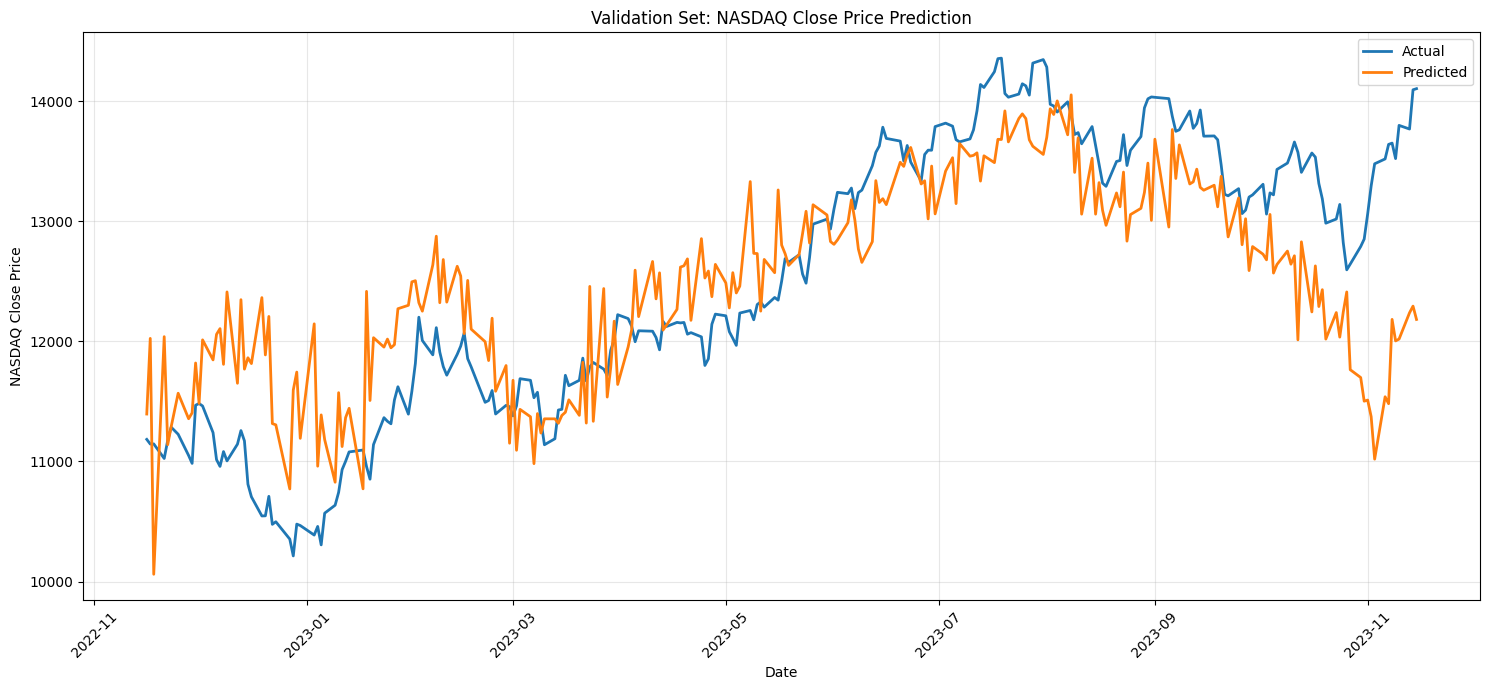


Test Set Performance Metrics:
MSE: 600493.94
RMSE: 774.92
MAE: 676.52
R2 Score: 0.6489


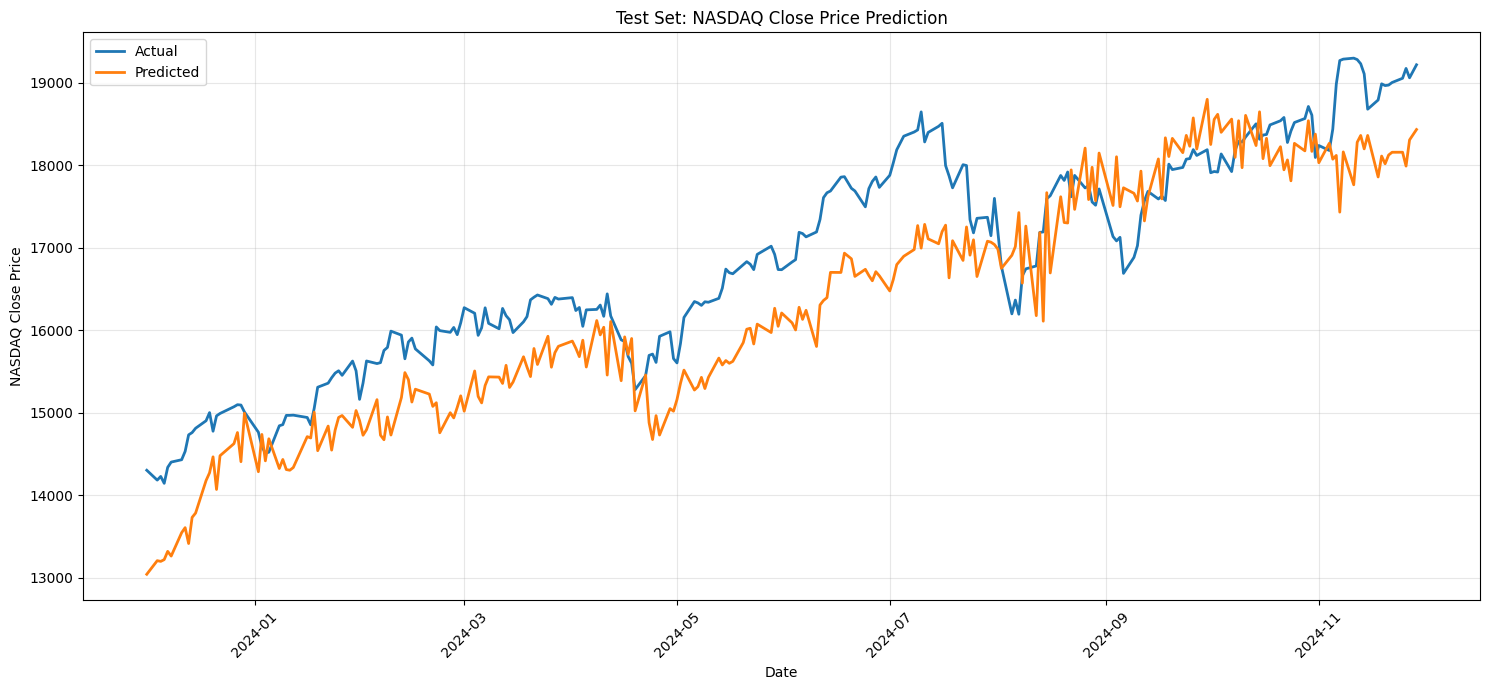

In [47]:
##########################################################################

#@title Create predictions with Best Params
def make_predictions(model, data_loader, scaler, data_columns):
    model.eval()  # Set model to evaluation mode
    predictions = []
    actuals = []

    with torch.no_grad():
        for features, targets in data_loader:
            output = model(features).squeeze()
            predictions.extend(output.numpy())
            actuals.extend(targets.numpy())

    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)

    predictions_dummy = np.zeros((len(predictions), len(data_columns)))
    actuals_dummy = np.zeros((len(actuals), len(data_columns)))

    nasdaq_idx = data_columns.index('nasdaq_close')
    predictions_dummy[:, nasdaq_idx] = predictions[:, 0]
    actuals_dummy[:, nasdaq_idx] = actuals[:, 0]

    predictions = scaler.inverse_transform(predictions_dummy)[:, nasdaq_idx]
    actuals = scaler.inverse_transform(actuals_dummy)[:, nasdaq_idx]

    return predictions, actuals

# Validation Set Evaluation
val_predictions, val_actuals = make_predictions(final_model, val_loader, scaler, data_columns)
val_metrics = calculate_metrics(val_actuals, val_predictions, "Validation Set")

# Plot validation predictions
plt.figure(figsize=(15, 7))
val_dates = data.index[train_size:train_size+val_size][-len(val_predictions):]
plt.plot(val_dates, val_actuals, label='Actual', linewidth=2)
plt.plot(val_dates, val_predictions, label='Predicted', linewidth=2)
plt.title('Validation Set: NASDAQ Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Test Set Evaluation
test_predictions, test_actuals = make_predictions(final_model, test_loader, scaler, data_columns)
test_metrics = calculate_metrics(test_actuals, test_predictions, "Test Set")

# Plot test predictions
plt.figure(figsize=(15, 7))
test_dates = data.index[train_size+val_size:][-len(test_predictions):]
plt.plot(test_dates, test_actuals, label='Actual', linewidth=2)
plt.plot(test_dates, test_predictions, label='Predicted', linewidth=2)
plt.title('Test Set: NASDAQ Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



---



## Make predictions to future dates